# 2D Gaussians problem setting

Visualizing the difference between unsupervised and semi-supervised subspace alignment.

In [1]:
import numpy as np
import numpy.random as rnd
import scipy.stats as st
import scipy.linalg as alg

In [2]:
import sys
sys.path.append("..")
from subalign import SubspaceAlignedClassifier, SemiSubspaceAlignedClassifier

In [3]:
%matplotlib inline
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set(style="whitegrid")

fS = 20
font = {'weight' : 'normal', 'size'   : fS}
matplotlib.rc('font', **font)

alphav = 0.5
clrs = ['r', 'b']

In [15]:
'''Generate data'''

# Dimensionality
D = 2

# Subspace dim
d = 2

# Number of classes
K = 2

# Sample sizes
N = 40
N0 = 20
N1 = N - N0
M = 40
M0 = 16
M1 = M - M0

# Number of target labels
Mu = 5

# Parameters source classes
muS0 = np.array([-4, -4])
muS1 = np.array([0, 0])
SiS0 = np.array([[3., -1.],[-1., 3]])
SiS1 = np.array([[3., -1.],[-1., 3]])

# Parameters target classes
muT0 = np.array([-2, 2])
muT1 = np.array([2, -2])
SiT0 = np.array([[3, 1.0],[1.0, 3]])
SiT1 = np.array([[3, 1.0],[1.0, 3]])

# Specify distributions
pS0 = st.multivariate_normal(muS0, SiS0)
pS1 = st.multivariate_normal(muS1, SiS1)
pT0 = st.multivariate_normal(muT0, SiT0)
pT1 = st.multivariate_normal(muT1, SiT1)

# Sample source data
X = np.concatenate((pS0.rvs(N0), pS1.rvs(N1)), axis=0)
Y = np.concatenate((np.zeros((N0,)), np.ones(N1,)), axis=0)

# Sample target data
Z = np.concatenate((pT0.rvs(M0), pT1.rvs(M1)), axis=0)
U = np.concatenate((np.zeros((M0,)), np.ones(M1,)), axis=0)

In [16]:
'''Select target samples to be labeled'''

u = np.zeros((K*Mu, 2), dtype='uint8')
u_ = np.zeros((M, K), dtype='bool')

for k in range(K):

    # Subsample
    ix = rnd.choice(np.arange(M), size=Mu, p=(U==k)/np.sum(U==k), replace=False)
    
    # Index array
    u[k*Mu:(k+1)*Mu, 0] = ix
    u[k*Mu:(k+1)*Mu, 1] = k
    
    # Boolean version
    u_[ix, k] = True
                

In [17]:
'''Find principal components in both domains and project'''

# Domain means
muX = np.mean(X, axis=0)[:, np.newaxis].T
muZ = np.mean(Z, axis=0)[:, np.newaxis].T

# Centered data
X_ = X - muX
Z_ = Z - muZ

# Estimate principal components manually
aX, CX = alg.eig(np.cov(X_.T))
aZ, CZ = alg.eig(np.cov(Z_.T))
aX = np.real(aX)
aZ = np.real(aZ)

# Sort components on decreasing eigenvalues
ixX = np.argsort(aX)[::-1]
ixZ = np.argsort(aZ)[::-1]
CX = CX[ixX,:]
CZ = CZ[ixZ,:]

# Map target data onto total target components
ZC = Z_ @ CZ + muZ

# Map source data onto total source components
XC = X_ @ CX + muX

In [18]:
'''Unsupervised alignment'''

# Swap axes matrix
A = [[0, 1], [-1, 0]]

# Optimal linear transformation matrix
W = CX.T @ CZ

# Map source data onto source principal components and align to target components
XW = X_ @ CX @ W @ A + muZ

In [47]:
'''Semi-supervised alignment'''

# Call instance of subalign
clf = SemiSubspaceAlignedClassifier(verbose=False)

# Obtain transformation matrix and components
V, CXk, _ = clf.semi_subspace_alignment(X, Y, Z, u, subspace_dim=d, pseudo_labeling=True, num_neighbours=Mu-1)

# Align each class
XV = np.zeros((N, d))
for k in range(K):
    
    # Class means
    muXk = np.mean(X[Y == k, :], axis=0)
    muZk = np.mean(ZC[u_[:,k], :], axis=0, keepdims=1)
    
    # Map source data onto source principal components and align to target components
    XV[Y == k, :] = (X[Y == k, :] - muXk) @ CXk[k] @ V[k] @ A + muZk

## Add error ellipses to distributions to better visualize rotations and translations in space

In [48]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

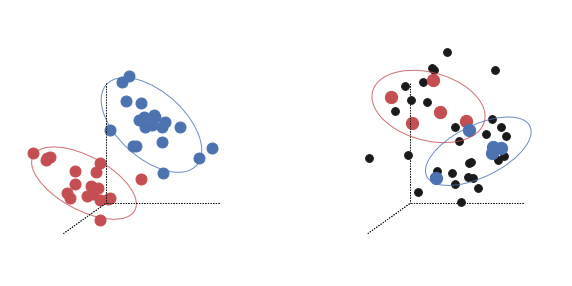

In [77]:
'''Visualize problem setting'''

# Figure subplot settings
fig = plt.figure(figsize=(10,5))        
ax0 = fig.add_subplot(121)
ax0.set_xlim([-10, 8])
ax0.set_ylim([-10, 8])
ax0.set_xticklabels(labels='')
ax0.set_yticklabels(labels='')
ax0.grid(False)
ax0.spines["left"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["bottom"].set_visible(False)

ax1 = fig.add_subplot(122, sharex=ax0, sharey=ax0)
ax1.grid(False)
ax1.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)

# Source data
confidence_ellipse(X[Y == 0, 0], X[Y == 0, 1], ax0, n_std=2.0, facecolor='none', edgecolor='r', alpha=0.8)
confidence_ellipse(X[Y == 1, 0], X[Y == 1, 1], ax0, n_std=2.0, facecolor='none', edgecolor='b', alpha=0.8)
ax0.scatter(X[Y == 0, 0], X[Y == 0, 1], c='r', s=120)
ax0.scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', s=120)
ax0.arrow(-3,-5,0,8, fc="k", ec="k", head_width=0., head_length=0., linestyle=':')
ax0.arrow(-3,-5,-3,-2, fc="k", ec="k", head_width=0., head_length=0., linestyle=':')
ax0.arrow(-3,-5,8,0, fc="k", ec="k", head_width=0., head_length=0., linestyle=':')

# Target data
ax1.scatter(Z[:, 0], Z[:, 1], c='k', s=60)
for k in range(K):
    confidence_ellipse(Z[u_[:,k], 0], Z[u_[:,k], 1], ax1, n_std=2.0, facecolor='none', edgecolor=clrs[k], alpha=0.8)
    ax1.scatter(Z[u_[:,k], 0], Z[u_[:,k], 1], c=clrs[k], s=150)

ax1.arrow(-3,-5,0,8, fc="k", ec="k", head_width=0., head_length=0., linestyle=":")
ax1.arrow(-3,-5,-3,-2, fc="k", ec="k", head_width=0., head_length=0., linestyle=':')
ax1.arrow(-3,-5,8,0, fc="k", ec="k", head_width=0., head_length=0., linestyle=':')

# Write figures to file
fig.savefig('viz/2DG_problem-setting_error-ellipses.png', bbox_inches='tight', padding=None)
fig.savefig('viz/2DG_problem-setting_error-ellipses.pdf', bbox_inches='tight', padding=None)

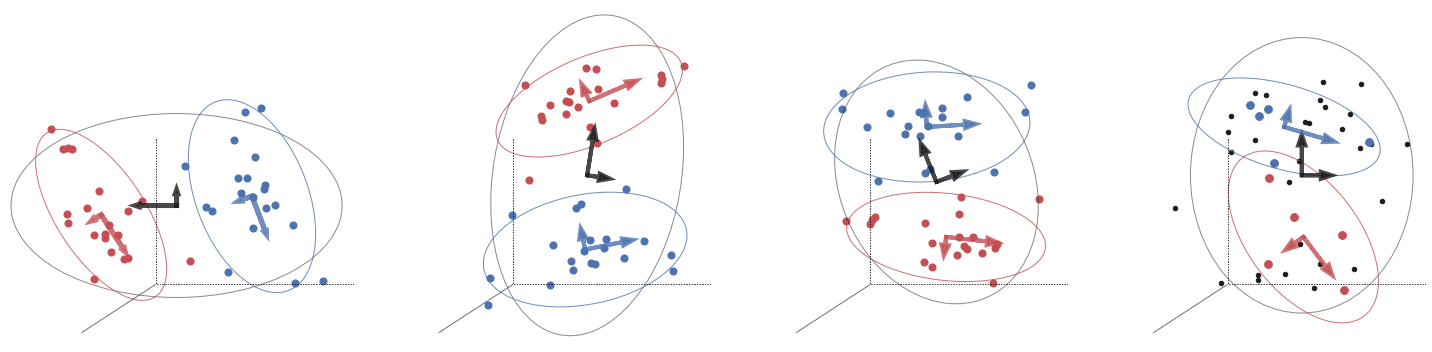

In [71]:
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(20,5))
ax[0].set_xlim([-9, 5])
ax[0].set_ylim([-7.5, 6.5])

'''Plot source data'''
confidence_ellipse(XC[:, 0], XC[:, 1], ax[0], n_std=2.0, facecolor='none', edgecolor='k', alpha=0.5)
confidence_ellipse(XC[Y == 0, 0], XC[Y == 0, 1], ax[0], n_std=2.0, facecolor='none', edgecolor='r', alpha=0.8)
confidence_ellipse(XC[Y == 1, 0], XC[Y == 1, 1], ax[0], n_std=2.0, facecolor='none', edgecolor='b', alpha=0.8)
ax[0].scatter(XC[Y == 0, 0], XC[Y == 0, 1], c='r', s=50)
ax[0].scatter(XC[Y == 1, 0], XC[Y == 1, 1], c='b', s=50)

ax[0].set_xticklabels(labels='')
ax[0].set_yticklabels(labels='')
ax[0].grid(False)
ax[0].spines["left"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)
ax[0].arrow(-3,-5,0,6, fc="k", ec="k", head_width=0.0, head_length=0.0, alpha=0.8, linestyle=':')
ax[0].arrow(-3,-5,-3, -2, fc="k", ec="k", head_width=0.0, head_length=0.0, alpha=0.8, linestyle=':')
ax[0].arrow(-3,-5,8,0, fc="k", ec="k", head_width=0.0, head_length=0.0, alpha=0.8, linestyle=':')

# Plot total eigenvectors
w,v = alg.eig(np.cov(XC.T))
w = 2*np.real(w) / np.sum(np.real(w))
centroid = np.mean(XC, 0)
ax[0].arrow(centroid[0], centroid[1], -w[0]*v[0,0], -w[0]*v[1,0], fc="k", ec="k", head_width=0.1, linewidth=5, alpha=0.8)
ax[0].arrow(centroid[0], centroid[1], w[1]*v[0,1], w[1]*v[1,1], fc="k", ec="k", head_width=0.1, linewidth=5, alpha=0.8)

# Plot class-specific eigenvectors
w,v = alg.eig(np.cov(XC[Y == 0, :].T))
w = 2*np.real(w) / np.sum(np.real(w))
centroid = np.mean(XC[Y == 0, :], 0)
ax[0].arrow(centroid[0], centroid[1], w[0]*v[0,0], w[0]*v[1,0], fc="r", ec="r", head_width=0.1, linewidth=5, alpha=0.8)
ax[0].arrow(centroid[0], centroid[1], w[1]*v[0,1], w[1]*v[1,1], fc="r", ec="r", head_width=0.1, linewidth=5, alpha=0.8)

w,v = alg.eig(np.cov(XC[Y == 1, :].T))
w = 2*np.real(w) / np.sum(np.real(w))
centroid = np.mean(XC[Y == 1, :], 0)
ax[0].arrow(centroid[0], centroid[1], w[0]*v[0,0], w[0]*v[1,0], fc="b", ec="b", head_width=0.1, linewidth=5, alpha=0.8)
ax[0].arrow(centroid[0], centroid[1], w[1]*v[0,1], w[1]*v[1,1], fc="b", ec="b", head_width=0.1, linewidth=5, alpha=0.8)


''' Plot unsupervised alignment'''
confidence_ellipse(XW[:, 0], XW[:, 1], ax[1], n_std=2.0, facecolor='none', edgecolor='k', alpha=0.5)
confidence_ellipse(XW[Y == 0, 0], XW[Y == 0, 1], ax[1], n_std=2.0, facecolor='none', edgecolor='r', alpha=0.8)
confidence_ellipse(XW[Y == 1, 0], XW[Y == 1, 1], ax[1], n_std=2.0, facecolor='none', edgecolor='b', alpha=0.8)
ax[1].scatter(XW[Y == 0, 0], XW[Y == 0, 1], c='r', s=50)
ax[1].scatter(XW[Y == 1, 0], XW[Y == 1, 1], c='b', s=50)

ax[1].set_xticklabels(labels='')
ax[1].set_yticklabels(labels='')
ax[1].grid(False)
ax[1].spines["left"].set_visible(False)
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["bottom"].set_visible(False)
ax[1].arrow(-3,-5,0,6, fc="k", ec="k", head_width=0., head_length=0., alpha=0.8, linestyle=':')
ax[1].arrow(-3,-5,-3, -2, fc="k", ec="k", head_width=0., head_length=0., alpha=0.8, linestyle=':')
ax[1].arrow(-3,-5,8,0, fc="k", ec="k", head_width=0., head_length=0., alpha=0.8, linestyle=':')

# Plot total eigenvectors
w,v = alg.eig(np.cov(XW.T))
w = 2*np.real(w) / np.sum(np.real(w))
centroid = np.mean(XW, 0)
ax[1].arrow(centroid[0], centroid[1], -w[0]*v[0,0], -w[0]*v[1,0], fc="k", ec="k", head_width=0.3, linewidth=4, alpha=0.8)
ax[1].arrow(centroid[0], centroid[1], -w[1]*v[0,1], -w[1]*v[1,1], fc="k", ec="k", head_width=0.3, linewidth=4, alpha=0.8)

# Plot class-specific eigenvectors
w,v = alg.eig(np.cov(XW[Y == 0, :].T))
w = 2*np.real(w) / np.sum(np.real(w))
centroid = np.mean(XW[Y == 0, :], 0)
ax[1].arrow(centroid[0], centroid[1], w[0]*v[0,0], w[0]*v[1,0], fc="r", ec="r", head_width=0.3, linewidth=4, alpha=0.8)
ax[1].arrow(centroid[0], centroid[1], w[1]*v[0,1], w[1]*v[1,1], fc="r", ec="r", head_width=0.3, linewidth=4, alpha=0.8)

w,v = alg.eig(np.cov(XW[Y == 1, :].T))
w = 2*np.real(w) / np.sum(np.real(w))
centroid = np.mean(XW[Y == 1, :], 0)
ax[1].arrow(centroid[0], centroid[1], w[0]*v[0,0], w[0]*v[1,0], fc="b", ec="b", head_width=0.3, linewidth=4, alpha=0.8)
ax[1].arrow(centroid[0], centroid[1], w[1]*v[0,1], w[1]*v[1,1], fc="b", ec="b", head_width=0.3, linewidth=4, alpha=0.8)

'''Plot semi-supervised alignment'''
confidence_ellipse(XV[:, 0], XV[:, 1], ax[2], n_std=2.0, facecolor='none', edgecolor='k', alpha=0.5)
confidence_ellipse(XV[Y==0, 0], XV[Y==0, 1], ax[2], n_std=2.0, facecolor='none', edgecolor='r', alpha=0.8)
confidence_ellipse(XV[Y==1, 0], XV[Y==1, 1], ax[2], n_std=2.0, facecolor='none', edgecolor='b', alpha=0.8)
ax[2].scatter(XV[Y==0, 0], XV[Y==0, 1], c='r', s=50)
ax[2].scatter(XV[Y==1, 0], XV[Y==1, 1], c='b', s=50)

ax[2].set_xticklabels(labels='')
ax[2].set_yticklabels(labels='')
ax[2].grid(False)
ax[2].spines["left"].set_visible(False)
ax[2].spines["right"].set_visible(False)
ax[2].spines["top"].set_visible(False)
ax[2].spines["bottom"].set_visible(False)
ax[2].arrow(-3,-5,0,6, fc="k", ec="k", head_width=0., head_length=0., alpha=0.8, linestyle=':')
ax[2].arrow(-3,-5,-3, -2, fc="k", ec="k", head_width=0., head_length=0., alpha=0.8, linestyle=':')
ax[2].arrow(-3,-5,8,0, fc="k", ec="k", head_width=0., head_length=0., alpha=0.8, linestyle=':')

# Plot total eigenvectors
w,v = alg.eig(np.cov(XV.T))
w = 2*np.real(w) / np.sum(np.real(w))
centroid = np.mean(XV, 0)
ax[2].arrow(centroid[0], centroid[1], -w[0]*v[0,0], -w[0]*v[1,0], fc="k", ec="k", head_width=0.3, linewidth=4, alpha=0.8)
ax[2].arrow(centroid[0], centroid[1], -w[1]*v[0,1], -w[1]*v[1,1], fc="k", ec="k", head_width=0.3, linewidth=4, alpha=0.8)

# Plot class-specific eigenvectors
w,v = alg.eig(np.cov(XV[Y == 0, :].T))
w = 2*np.real(w) / np.sum(np.real(w))
centroid = np.mean(XV[Y == 0, :], 0)
ax[2].arrow(centroid[0], centroid[1], w[0]*v[0,0], w[0]*v[1,0], fc="r", ec="r", head_width=0.3, linewidth=4, alpha=0.8)
ax[2].arrow(centroid[0], centroid[1], -w[1]*v[0,1], -w[1]*v[1,1], fc="r", ec="r", head_width=0.3, linewidth=4, alpha=0.8)

w,v = alg.eig(np.cov(XV[Y == 1, :].T))
w = 2*np.real(w) / np.sum(np.real(w))
centroid = np.mean(XV[Y == 1, :], 0)
ax[2].arrow(centroid[0], centroid[1], w[0]*v[0,0], w[0]*v[1,0], fc="b", ec="b", head_width=0.3, linewidth=4, alpha=0.8)
ax[2].arrow(centroid[0], centroid[1], w[1]*v[0,1], w[1]*v[1,1], fc="b", ec="b", head_width=0.3, linewidth=4, alpha=0.8)

'''Plot target data'''
confidence_ellipse(ZC[:, 0], ZC[:, 1], ax[3], n_std=2.0, facecolor='none', edgecolor='k', alpha=0.5)
confidence_ellipse(ZC[u_[:,0], 0], ZC[u_[:,0], 1], ax[3], n_std=2.0, facecolor='none', edgecolor='r', alpha=0.8)
confidence_ellipse(ZC[u_[:,1], 0], ZC[u_[:,1], 1], ax[3], n_std=2.0, facecolor='none', edgecolor='b', alpha=0.8)
ax[3].scatter(ZC[:, 0], ZC[:, 1], c='k', s=20)
ax[3].scatter(ZC[u_[:,0], 0], ZC[u_[:,0], 1], c=clrs[0], s=60)
ax[3].scatter(ZC[u_[:,1], 0], ZC[u_[:,1], 1], c=clrs[1], s=60)

# Plot total eigenvectors
w,v = alg.eig(np.cov(ZC.T))
w = 2*np.real(w) / np.sum(np.real(w))
centroid = np.mean(ZC, 0)
ax[3].arrow(centroid[0], centroid[1], w[0]*v[0,0], w[0]*v[1,0], fc="k", ec="k", head_width=0.3, linewidth=4, alpha=0.8)
ax[3].arrow(centroid[0], centroid[1], w[1]*v[0,1], w[1]*v[1,1], fc="k", ec="k", head_width=0.3, linewidth=4, alpha=0.8)

# Plot class-specific eigenvectors
w,v = alg.eig(np.cov(ZC[u_[:,0], :].T))
w = 2*np.real(w) / np.sum(np.real(w))
centroid = np.mean(ZC[u_[:,0], :], 0)
ax[3].arrow(centroid[0], centroid[1], w[0]*v[0,0], w[0]*v[1,0], fc="r", ec="r", head_width=0.3, linewidth=4, alpha=0.8)
ax[3].arrow(centroid[0], centroid[1], w[1]*v[0,1], w[1]*v[1,1], fc="r", ec="r", head_width=0.3, linewidth=4, alpha=0.8)

w,v = alg.eig(np.cov(ZC[u_[:,1], :].T))
w = 2*np.real(w) / np.sum(np.real(w))
centroid = np.mean(ZC[u_[:,1], :], 0)
ax[3].arrow(centroid[0], centroid[1], w[0]*v[0,0], w[0]*v[1,0], fc="b", ec="b", head_width=0.3, linewidth=4, alpha=0.8)
ax[3].arrow(centroid[0], centroid[1], w[1]*v[0,1], w[1]*v[1,1], fc="b", ec="b", head_width=0.3, linewidth=4, alpha=0.8)

# ax[3].set_xlabel('$x_1$', fontsize=fS)
ax[3].set_xticklabels(labels='')
ax[3].set_yticklabels(labels='')
ax[3].grid(False)
ax[3].spines["left"].set_visible(False)
ax[3].spines["right"].set_visible(False)
ax[3].spines["top"].set_visible(False)
ax[3].spines["bottom"].set_visible(False)
ax[3].arrow(-3,-5,0,6, fc="k", ec="k", head_width=0., head_length=0., alpha=0.8, linestyle=':')
ax[3].arrow(-3,-5,-3,-2, fc="k", ec="k", head_width=0., head_length=0., alpha=0.8, linestyle=':')
ax[3].arrow(-3,-5,8,0, fc="k", ec="k", head_width=0., head_length=0., alpha=0.8, linestyle=':')

plt.tight_layout()
fig.savefig('viz/2DG_subalign_error-ellips.png', bbox_inches='tight', padding=None)
fig.savefig('viz/2DG_subalign_error-ellips.pdf', bbox_inches='tight', padding=None)

## Adding text to points to provide better example for NLP

In [73]:
'''Text for in plots'''

words_S0 = ["network", "learning", "intelligent"]
words_S1 = ["bert", "ernie", "johnson"]
words_T0 = ["bert", "network", "learning"]
words_T1 = ["ernie", "johnson", "tusk"]

In [66]:
import numpy.random as rnd

# Number of points to assign text to
num_subset = 3

# Split by class
XC0 = XC[Y == 0, :]
XC1 = XC[Y == 1, :]

# Sample index
nX0 = XC0.shape[0]
nX1 = XC1.shape[0]
ix0 = rnd.choice(range(nX0), size=num_subset, replace=False)
ix1 = rnd.choice(range(nX1), size=num_subset, replace=False)
XC0 = XC0[ix0,:]
XC1 = XC1[ix1,:]

# Select from labeled target samples
ZCu0 = ZC[u_[:,0], :]
ZCu1 = ZC[u_[:,1], :]

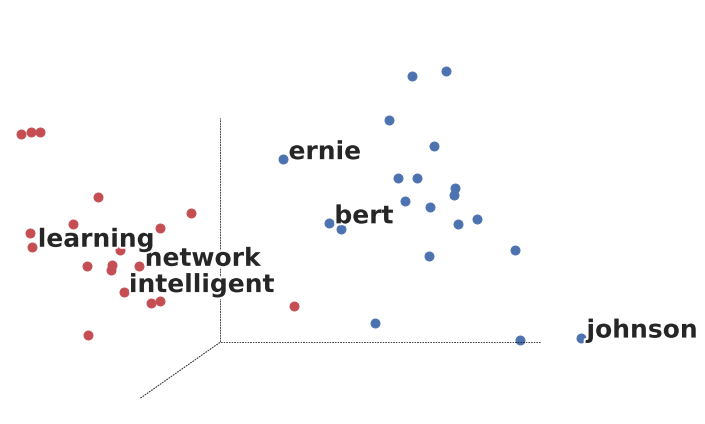

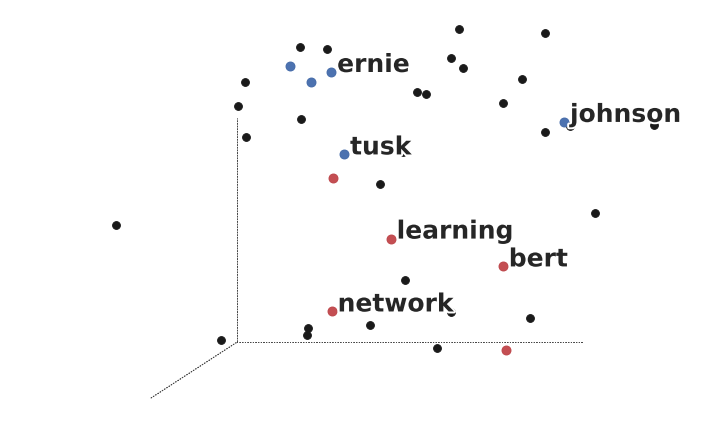

In [75]:
from  matplotlib.patheffects import Stroke, Normal

'''Visualize problem setting'''

# Source domain's axes properties
fig = plt.figure(figsize=(10,6))        
ax0 = fig.add_subplot(111)
ax0.set_xlim([-7,5])
ax0.set_ylim([-7,4])  
ax0.set_xticklabels(labels='')
ax0.set_yticklabels(labels='')
ax0.grid(False)
ax0.spines["left"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["bottom"].set_visible(False)
ax0.arrow(-3,-5,0,6, fc="k", ec="k", head_width=0., head_length=0., alpha=.8, linestyle=':')
ax0.arrow(-3,-5,-1.5,-1.5, fc="k", ec="k", head_width=0., head_length=0., alpha=.8, linestyle=':')
ax0.arrow(-3,-5,6,0, fc="k", ec="k", head_width=0., head_length=0., alpha=.8, linestyle=':')

# Dots and text
ax0.scatter(XC[Y==0, 0], XC[Y==0, 1], c='r', s=80)
ax0.scatter(XC[Y==1, 0], XC[Y==1, 1], c='b', s=80)
for ii in range(num_subset):
    txt0 = ax0.text(XC0[ii,0]+0.1, XC0[ii,1], words_S0[ii], fontsize=25, fontweight='bold')
    txt1 = ax0.text(XC1[ii,0]+0.1, XC1[ii,1], words_S1[ii], fontsize=25, fontweight='bold')
    txt0.set_path_effects([Stroke(linewidth=4, foreground='white'), Normal()]) 
    txt1.set_path_effects([Stroke(linewidth=4, foreground='white'), Normal()]) 

# Write to file
plt.tight_layout()
fig.savefig('viz/2DG_problem-setting-src_annotated.png', bbox_inches='tight', padding=None)
fig.savefig('viz/2DG_problem-setting-src_annotated.pdf', bbox_inches='tight', padding=None)

# Target domain's axes properties
fig = plt.figure(figsize=(10,6))        
ax1 = fig.add_subplot(111)
ax1.set_xlim([-7,5])
ax1.set_ylim([-7,4])
ax1.set_xticklabels(labels='')
ax1.set_yticklabels(labels='')
ax1.grid(False)
ax1.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.arrow(-3,-5,0,6, fc="k", ec="k", head_width=0., head_length=0., alpha=.8, linestyle=':')
ax1.arrow(-3,-5,-1.5,-1.5, fc="k", ec="k", head_width=0., head_length=0., alpha=.8, linestyle=':')
ax1.arrow(-3,-5,6,0, fc="k", ec="k", head_width=0., head_length=0., alpha=.8, linestyle=':')

ax1.scatter(ZC[:, 0], ZC[:, 1], c='k', s=60)
ax1.scatter(ZC[u_[:,0], 0], ZC[u_[:,0], 1], c=clrs[0], s=80)
ax1.scatter(ZC[u_[:,1], 0], ZC[u_[:,1], 1], c=clrs[1], s=80)
for ii in range(num_subset):
    txt0 = ax1.text(ZCu0[ii,0]+0.1, ZCu0[ii,1], words_T0[ii], fontsize=25, fontweight='bold')
    txt0.set_path_effects([Stroke(linewidth=4, foreground='white'), Normal()]) 
for ii in range(num_subset):
    txt1 = ax1.text(ZCu1[ii,0]+0.1, ZCu1[ii,1], words_T1[ii], fontsize=25, fontweight='bold')
    txt1.set_path_effects([Stroke(linewidth=4, foreground='white'), Normal()]) 
    
# Write to file
plt.tight_layout()
fig.savefig('viz/2DG_problem-setting-tgt_annotated.png', bbox_inches='tight', padding=None)
fig.savefig('viz/2DG_problem-setting-tgt_annotated.pdf', bbox_inches='tight', padding=None)